In [ ]:
!pip install numpy matplotlib scikit-learn


In [ ]:
import os
import zipfile
import random
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans


In [4]:
zip_path = "/content/tsplib-master.zip"
extract_path = "/content/tsplib"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Dataset extracted successfully")


Dataset extracted successfully


In [5]:
tsp_files = []

for root, dirs, files in os.walk(extract_path):
    for file in files:
        if file.endswith(".tsp"):
            tsp_files.append(os.path.join(root, file))

print("Total TSP files found:", len(tsp_files))
print("Sample files:")
for f in tsp_files[:5]:
    print(f)


Total TSP files found: 111
Sample files:
/content/tsplib/u2319.tsp
/content/tsplib/pr2392.tsp
/content/tsplib/gr48.tsp
/content/tsplib/eil51.tsp
/content/tsplib/kroC100.tsp


In [6]:
def load_tsp(file_path):
    points = []
    read_coords = False

    with open(file_path, "r", encoding="latin-1") as f:
        for line in f:
            line = line.strip()

            if line == "NODE_COORD_SECTION":
                read_coords = True
                continue

            if line == "EOF":
                break

            if read_coords:
                parts = line.split()
                if len(parts) >= 3:
                    points.append([float(parts[1]), float(parts[2])])

    return np.array(points)


In [9]:
# CHANGE INDEX TO TEST OTHER DATASETS
tsp_file = [f for f in tsp_files if "a280" in f][0]

points = load_tsp(tsp_file)

print("Using dataset:", os.path.basename(tsp_file))
print("Total disaster locations:", len(points))


Using dataset: a280.tsp
Total disaster locations: 280


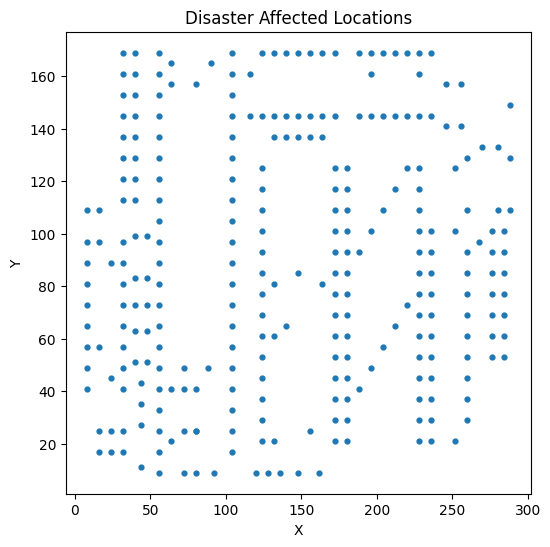

In [10]:
plt.figure(figsize=(6,6))
plt.scatter(points[:,0], points[:,1], s=12)
plt.title("Disaster Affected Locations")
plt.xlabel("X")
plt.ylabel("Y")
plt.show()


In [11]:
def compute_distance_matrix(points):
    n = len(points)
    matrix = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            matrix[i][j] = np.linalg.norm(points[i] - points[j])
    return matrix

distance_matrix = compute_distance_matrix(points)


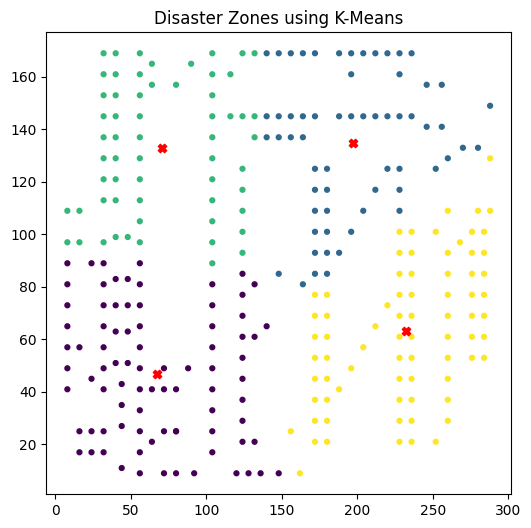

In [12]:
k = 4
kmeans = KMeans(n_clusters=k, random_state=42)
labels = kmeans.fit_predict(points)
centers = kmeans.cluster_centers_

plt.figure(figsize=(6,6))
plt.scatter(points[:,0], points[:,1], c=labels, s=12)
plt.scatter(centers[:,0], centers[:,1], c='red', marker='X')
plt.title("Disaster Zones using K-Means")
plt.show()


In [13]:
class Chromosome:
    def __init__(self, genes):
        self.genes = genes
        self.fitness = 0

    def calculate_fitness(self, distance_matrix):
        total_distance = 0
        for i in range(len(self.genes)-1):
            total_distance += distance_matrix[self.genes[i]][self.genes[i+1]]
        self.fitness = 1 / (total_distance + 1)


In [14]:
def create_population(size, num_nodes):
    population = []
    for _ in range(size):
        genes = list(range(num_nodes))
        random.shuffle(genes)
        population.append(Chromosome(genes))
    return population

def crossover(p1, p2):
    size = len(p1.genes)
    a, b = sorted(random.sample(range(size), 2))
    child = [-1] * size
    child[a:b] = p1.genes[a:b]

    ptr = 0
    for g in p2.genes:
        if g not in child:
            while child[ptr] != -1:
                ptr += 1
            child[ptr] = g
    return Chromosome(child)

def mutation(chromo, rate=0.02):
    for i in range(len(chromo.genes)):
        if random.random() < rate:
            j = random.randint(0, len(chromo.genes)-1)
            chromo.genes[i], chromo.genes[j] = chromo.genes[j], chromo.genes[i]


In [15]:
MAX_DISTANCE = np.mean(distance_matrix) * len(points) * 0.5

def constraint_satisfied(route, distance_matrix):
    dist = 0
    for i in range(len(route)-1):
        dist += distance_matrix[route[i]][route[i+1]]
    return dist <= MAX_DISTANCE


In [16]:
POP_SIZE = 100
GENERATIONS = 200
MAX_TRIES = 10
MUTATION_RATE = 0.01

population = create_population(POP_SIZE, len(points))

for gen in range(GENERATIONS):

    # Fitness calculation
    for chromo in population:
        chromo.calculate_fitness(distance_matrix)

    # Sort by fitness
    population.sort(key=lambda x: x.fitness, reverse=True)

    # Selection (at least 2 parents)
    selected = population[:max(2, POP_SIZE // 2)]
    new_population = selected.copy()  # elitism

    tries = 0
    while len(new_population) < POP_SIZE and tries < POP_SIZE * MAX_TRIES:
        tries += 1

        p1, p2 = random.sample(selected, 2)
        child = crossover(p1, p2)
        mutation(child, rate=MUTATION_RATE)

        if constraint_satisfied(child.genes, distance_matrix):
            new_population.append(child)

    # Fallback safety
    while len(new_population) < POP_SIZE:
        genes = list(range(len(points)))
        random.shuffle(genes)
        new_population.append(Chromosome(genes))

    population = new_population

    if gen % 10 == 0:
        print(f"Generation {gen} | Best Fitness: {population[0].fitness:.6f}")


Generation 0 | Best Fitness: 0.000032
Generation 10 | Best Fitness: 0.000032
Generation 20 | Best Fitness: 0.000032
Generation 30 | Best Fitness: 0.000032
Generation 40 | Best Fitness: 0.000032
Generation 50 | Best Fitness: 0.000032
Generation 60 | Best Fitness: 0.000032
Generation 70 | Best Fitness: 0.000032
Generation 80 | Best Fitness: 0.000033
Generation 90 | Best Fitness: 0.000033
Generation 100 | Best Fitness: 0.000033
Generation 110 | Best Fitness: 0.000033
Generation 120 | Best Fitness: 0.000033
Generation 130 | Best Fitness: 0.000033
Generation 140 | Best Fitness: 0.000033
Generation 150 | Best Fitness: 0.000033
Generation 160 | Best Fitness: 0.000033
Generation 170 | Best Fitness: 0.000033
Generation 180 | Best Fitness: 0.000033
Generation 190 | Best Fitness: 0.000033


In [17]:
best_solution = max(population, key=lambda x: x.fitness)
best_route = best_solution.genes

print("Optimization completed successfully")


Optimization completed successfully


In [18]:
def route_distance(route, distance_matrix):
    dist = 0
    for i in range(len(route) - 1):
        dist += distance_matrix[route[i]][route[i+1]]
    return dist


In [19]:
# Initial random route (baseline)
initial_route = list(range(len(points)))
random.shuffle(initial_route)

initial_distance = route_distance(initial_route, distance_matrix)
optimized_distance = route_distance(best_route, distance_matrix)

improvement = ((initial_distance - optimized_distance) / initial_distance) * 100

print("Initial Route Distance:", round(initial_distance, 2))
print("Optimized Route Distance:", round(optimized_distance, 2))
print("Improvement (%):", round(improvement, 2))


Initial Route Distance: 33165.69
Optimized Route Distance: 30736.96
Improvement (%): 7.32


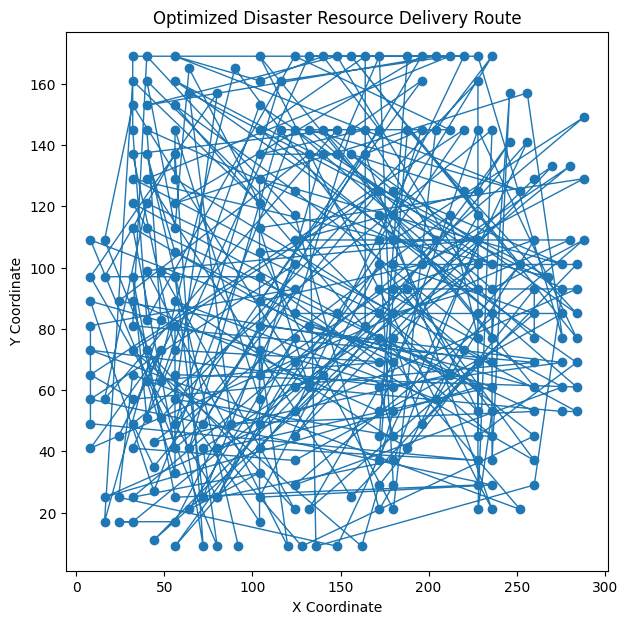

In [20]:
x = [points[i][0] for i in best_route]
y = [points[i][1] for i in best_route]

plt.figure(figsize=(7,7))
plt.plot(x, y, marker='o', linewidth=1)
plt.title("Optimized Disaster Resource Delivery Route")
plt.xlabel("X Coordinate")
plt.ylabel("Y Coordinate")
plt.show()
